# 🚀 Implement Caching Lab - Interactive Edition

**Duration:** 45-60 minutes  
**Level:** Intermediate

Welcome to the interactive caching lab! In this hands-on notebook, you'll:

- ✅ Implement the **cache-aside pattern** with Redis
- ✅ Use **real PostgreSQL database** with Docker
- ✅ Measure **real performance improvements** (10-100x speedup)
- ✅ Visualize cache effectiveness with **interactive charts**
- ✅ Learn cache invalidation strategies
- ✅ Apply best practices for production systems

**Real infrastructure!** We'll use Docker to run PostgreSQL and Redis, giving you hands-on experience with production-grade caching.

## 📚 What You'll Learn

By the end of this lab, you'll understand:

1. **Cache-Aside Pattern** - The most common caching strategy
2. **Performance Measurement** - Quantify latency improvements
3. **Hit Rate Optimization** - Maximize cache effectiveness
4. **Cache Invalidation** - Keep data fresh and consistent
5. **TTL Strategy** - Balance freshness vs. performance

Let's get started! 🎯

---
## Part 1: Setup and Dependencies (5 minutes)

First, let's import all the packages we'll need.

---
## Part 1: Infrastructure Setup with Docker (10 minutes)

We'll use Docker to run real databases. This gives you hands-on experience with production infrastructure!

### 🐳 Start PostgreSQL and Redis with Docker

Run the following cell to start both databases. This will:
- Pull PostgreSQL 15 and Redis 7 images (if not already available)
- Start PostgreSQL on port 5432
- Start Redis on port 6379
- Create a sample database with product data

In [1]:
import subprocess
import time

print("🚀 Setting up PostgreSQL and Redis containers...\n")


def run_command(cmd, ignore_errors=False):
    """Run shell command and return output"""
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    if not ignore_errors and result.returncode != 0:
        return None, result.stderr
    return result.stdout, None


# Stop and remove existing containers
print("🧹 Cleaning up existing containers...")
run_command(
    "docker stop workshop-postgres workshop-redis 2>/dev/null", ignore_errors=True)
run_command("docker rm workshop-postgres workshop-redis 2>/dev/null",
            ignore_errors=True)
time.sleep(2)

# Start PostgreSQL
print("📦 Starting PostgreSQL 15...")
pg_out, pg_err = run_command("""
docker run -d \
  --name workshop-postgres \
  -e POSTGRES_PASSWORD=workshop123 \
  -e POSTGRES_USER=workshop \
  -e POSTGRES_DB=workshop \
  -p 5432:5432 \
  postgres:15-alpine
""")

if pg_err and "port is already allocated" in pg_err:
    print("   ⚠️  Port 5432 is already in use. Checking for existing container...")
    existing, _ = run_command("docker ps -q -f name=workshop-postgres")
    if existing.strip():
        print("   ✅ Using existing PostgreSQL container")
    else:
        print("   ❌ Port conflict! Please stop the service using port 5432")
elif pg_err:
    print(f"   ❌ Error: {pg_err.strip()}")
else:
    print("   ✅ PostgreSQL started successfully")

# Start Redis
print("📦 Starting Redis 7...")
redis_out, redis_err = run_command("""
docker run -d \
  --name workshop-redis \
  -p 6379:6379 \
  redis:7-alpine
""")

if redis_err and "port is already allocated" in redis_err:
    print("   ⚠️  Port 6379 is already in use. Checking for existing container...")
    existing, _ = run_command("docker ps -q -f name=workshop-redis")
    if existing.strip():
        print("   ✅ Using existing Redis container")
    else:
        print("   ℹ️  Using existing Redis service on port 6379")
elif redis_err:
    print(f"   ❌ Error: {redis_err.strip()}")
else:
    print("   ✅ Redis started successfully")

# Wait for services to be ready
print("\n⏳ Waiting for services to be ready...")
time.sleep(3)

# Check status
print("\n📊 Container Status:")
status, _ = run_command(
    'docker ps --filter "name=workshop-" --format "table {{.Names}}\t{{.Status}}\t{{.Ports}}"', ignore_errors=True)
if status:
    print(status)

# Test connections
print("\n🔌 Testing connections...")

# Test PostgreSQL
pg_test, _ = run_command(
    "docker exec workshop-postgres pg_isready -U workshop", ignore_errors=True)
if pg_test and "accepting connections" in pg_test:
    print("   ✅ PostgreSQL is ready")
else:
    print("   ⚠️  PostgreSQL connection test failed (container may still be starting)")

# Test Redis
redis_test, _ = run_command(
    "docker exec workshop-redis redis-cli ping 2>/dev/null", ignore_errors=True)
if redis_test and "PONG" in redis_test:
    print("   ✅ Redis is ready")
else:
    # Try connecting to host Redis
    try:
        import redis
        r = redis.Redis(host='localhost', port=6379,
                        decode_responses=True, socket_timeout=1)
        r.ping()
        print("   ✅ Redis is ready (host service)")
    except:
        print("   ⚠️  Redis connection test failed")

print("\n✅ Setup complete! You can proceed to the next cell.")

🚀 Setting up PostgreSQL and Redis containers...

🧹 Cleaning up existing containers...
📦 Starting PostgreSQL 15...
   ✅ PostgreSQL started successfully
📦 Starting Redis 7...
📦 Starting PostgreSQL 15...
   ✅ PostgreSQL started successfully
📦 Starting Redis 7...
   ❌ Error: docker: Error response from daemon: failed to set up container networking: driver failed programming external connectivity on endpoint workshop-redis (a19f9b4e49133170d162a62e379ae4973aa2b13977b898bd668409d322182b00): failed to bind host port for 0.0.0.0:6379:172.17.0.3:6379/tcp: address already in use

Run 'docker run --help' for more information

⏳ Waiting for services to be ready...
   ❌ Error: docker: Error response from daemon: failed to set up container networking: driver failed programming external connectivity on endpoint workshop-redis (a19f9b4e49133170d162a62e379ae4973aa2b13977b898bd668409d322182b00): failed to bind host port for 0.0.0.0:6379:172.17.0.3:6379/tcp: address already in use

Run 'docker run --help

### 📦 Install Python Dependencies

Install the required packages for PostgreSQL and Redis connections:

In [ ]:
!pip install -q psycopg2-binary redis pandas matplotlib

print("✅ All packages installed successfully!")

In [ ]:
# 🎨 RUN THIS FIRST!
from IPython.display import display, HTML; from pathlib import Path
display(HTML(f'<style>{Path("workshops/deploy-redis-for-developers-amr/module-08-implement-caching-lab/notebook-styles.css").read_text()}</style>'))

✅ Notebook styling loaded!


---
## Part 2: Setup PostgreSQL Database (5 minutes)

### 🗄️ Create Database Schema and Load Sample Data

Let's create a products table and populate it with realistic e-commerce data:

In [ ]:
import psycopg2
from psycopg2.extras import execute_values
import time

# Database connection parameters
DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'workshop',
    'user': 'workshop',
    'password': 'workshop123'
}

# Connect to PostgreSQL
print("🔌 Connecting to PostgreSQL...")
conn = psycopg2.connect(**DB_CONFIG)
cur = conn.cursor()

# Create products table
print("📋 Creating products table...")
cur.execute("""
    DROP TABLE IF EXISTS products CASCADE;
    
    CREATE TABLE products (
        id SERIAL PRIMARY KEY,
        name VARCHAR(255) NOT NULL,
        price DECIMAL(10, 2) NOT NULL,
        category VARCHAR(100) NOT NULL,
        stock INTEGER NOT NULL,
        description TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
    
    CREATE INDEX idx_products_category ON products(category);
    CREATE INDEX idx_products_price ON products(price);
""")

# Sample product data
products = [
    ("Laptop Pro 15", 999.99, "Electronics", 50,
     "High-performance laptop with 15-inch display"),
    ("Wireless Mouse", 29.99, "Electronics", 200,
     "Ergonomic wireless mouse with long battery life"),
    ("USB-C Cable", 12.99, "Accessories", 500, "Durable USB-C to USB-C cable, 6ft"),
    ("4K Monitor", 399.99, "Electronics", 30,
     "27-inch 4K UHD monitor with HDR support"),
    ("Mechanical Keyboard", 89.99, "Electronics", 75,
     "RGB mechanical keyboard with blue switches"),
    ("Desk Lamp", 34.99, "Office", 120, "LED desk lamp with adjustable brightness"),
    ("Ergonomic Chair", 299.99, "Furniture", 40,
     "Comfortable office chair with lumbar support"),
    ("Webcam HD", 69.99, "Electronics", 90,
     "1080p HD webcam with built-in microphone"),
    ("Headphones", 149.99, "Electronics", 60,
     "Noise-cancelling over-ear headphones"),
    ("Phone Stand", 19.99, "Accessories", 300,
     "Adjustable smartphone stand for desk")
]

# Insert products
print(f"💾 Inserting {len(products)} products...")
execute_values(
    cur,
    "INSERT INTO products (name, price, category, stock, description) VALUES %s",
    products
)

conn.commit()

# Verify data
cur.execute("SELECT COUNT(*) FROM products")
count = cur.fetchone()[0]

print(f"✅ Database setup complete!")
print(f"   Table: products")
print(f"   Rows: {count}")
print(f"   Ready for caching tests!")

cur.close()
conn.close()

🔌 Connecting to PostgreSQL...
📋 Creating products table...
💾 Inserting 10 products...
✅ Database setup complete!
   Table: products
   Rows: 10
   Ready for caching tests!


### ✅ Test Database Connection

Let's verify the connection works and see some sample data:

In [5]:
import psycopg2
import pandas as pd

# Connect to database
conn = psycopg2.connect(**DB_CONFIG)
cur = conn.cursor()

# Query products
cur.execute("""
    SELECT id, name, price, category, stock 
    FROM products 
    ORDER BY id 
    LIMIT 5
""")

# Fetch results
rows = cur.fetchall()
columns = [desc[0] for desc in cur.description]

# Display as DataFrame
df = pd.DataFrame(rows, columns=columns)
print("📦 Sample Products in Database:\n")
print(df.to_string(index=False))

# Get statistics
cur.execute("""
    SELECT 
        COUNT(*) as total_products,
        COUNT(DISTINCT category) as total_categories,
        ROUND(AVG(price), 2) as avg_price
    FROM products
""")

stats = cur.fetchone()
print(f"\n📊 Database Statistics:")
print(f"   Total Products: {stats[0]}")
print(f"   Categories: {stats[1]}")
print(f"   Average Price: ${stats[2]}")

cur.close()
conn.close()

print("\n✅ Connection test successful!")

📦 Sample Products in Database:

 id                name  price    category  stock
  1       Laptop Pro 15 999.99 Electronics     50
  2      Wireless Mouse  29.99 Electronics    200
  3         USB-C Cable  12.99 Accessories    500
  4          4K Monitor 399.99 Electronics     30
  5 Mechanical Keyboard  89.99 Electronics     75

📊 Database Statistics:
   Total Products: 10
   Categories: 4
   Average Price: $210.79

✅ Connection test successful!


In [6]:
# Core libraries
import redis
import time
import json
import random
from typing import Dict, Optional, List

# Data visualization
import matplotlib.pyplot as plt
import pandas as pd

# Configure matplotlib for inline display
%matplotlib inline

print("✅ All packages imported successfully!")

✅ All packages imported successfully!


### 🔧 Configure Redis Connection

We'll connect to Redis running locally in Codespaces. You can also connect to Azure Redis by changing the configuration.

In [7]:
# Redis configuration
USE_LOCAL_REDIS = True  # Set to False for Azure Redis

if USE_LOCAL_REDIS:
    # Local Redis (in Codespaces)
    redis_client = redis.Redis(
        host='localhost',
        port=6379,
        decode_responses=True  # Return strings instead of bytes
    )
else:
    # Azure Redis (update with your values)
    redis_client = redis.Redis(
        host='your-cache.redis.cache.windows.net',
        port=6380,
        password='your-access-key',
        ssl=True,
        decode_responses=True
    )

# Test connection
try:
    redis_client.ping()
    print("✅ Connected to Redis successfully!")
    print(f"   Server info: {redis_client.info('server')['redis_version']}")
except Exception as e:
    print(f"❌ Redis connection failed: {e}")
    print("   Make sure Redis is running: sudo service redis-server start")

✅ Connected to Redis successfully!
   Server info: 7.0.15


---
## Part 3: Create Database Wrapper (5 minutes)

Let's create a wrapper class for our PostgreSQL database that tracks query performance:

In [ ]:
import psycopg2
from psycopg2.extras import RealDictCursor


class PostgreSQLDatabase:
    """
    Wrapper for PostgreSQL database operations.
    Tracks query count and provides clean interface for product queries.
    """

    def __init__(self, config=None):
        """Initialize database connection"""
        if config is None:
            config = DB_CONFIG

        self.config = config
        self.conn = None
        self.query_count = 0
        self._connect()

    def _connect(self):
        """Establish database connection"""
        if self.conn is None or self.conn.closed:
            self.conn = psycopg2.connect(**self.config)

    def get_product_by_id(self, product_id: int) -> Optional[Dict]:
        """
        Query product by ID from PostgreSQL.
        Returns product data as dictionary or None if not found.
        """
        self._connect()

        with self.conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute(
                "SELECT id, name, price, category, stock FROM products WHERE id = %s",
                (product_id,)
            )
            result = cur.fetchone()

            self.query_count += 1

            # Convert RealDictRow to regular dict if found
            return dict(result) if result else None

    def get_products_by_category(self, category: str) -> List[Dict]:
        """Query all products in a category"""
        self._connect()

        with self.conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute(
                "SELECT id, name, price, category, stock FROM products WHERE category = %s",
                (category,)
            )
            results = cur.fetchall()

            self.query_count += 1

            return [dict(row) for row in results]

    def reset_stats(self):
        """Reset query counter"""
        self.query_count = 0

    def close(self):
        """Close database connection"""
        if self.conn and not self.conn.closed:
            self.conn.close()


# Create database instance
db = PostgreSQLDatabase()
print(f"✅ PostgreSQL database wrapper created")
print(f"   Connection: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
print(f"   Database: {DB_CONFIG['database']}")

✅ PostgreSQL database wrapper created
   Connection: localhost:5432
   Database: workshop


### 🧪 Test the PostgreSQL Database

Let's verify our database wrapper works and measure real query latency:

In [9]:
# Test database query with timing
start_time = time.time()
product = db.get_product_by_id(1)
elapsed_ms = (time.time() - start_time) * 1000

print(f"Product: {product['name']}")
print(f"Price: ${product['price']}")
print(f"Category: {product['category']}")
print(f"Stock: {product['stock']} units")
print(f"\n⏱️  Query time: {elapsed_ms:.2f}ms")
print(f"📊 Total queries: {db.query_count}")

print("\n💡 Real database query latency will vary based on:")
print("   - Network latency")
print("   - Database load")
print("   - Query complexity")
print("   - Index usage")

Product: Laptop Pro 15
Price: $999.99
Category: Electronics
Stock: 50 units

⏱️  Query time: 9.06ms
📊 Total queries: 1

💡 Real database query latency will vary based on:
   - Network latency
   - Database load
   - Query complexity
   - Index usage


---
## Part 4: Implement Cache-Aside Pattern (15 minutes)

Now let's implement the **cache-aside pattern** (also called "lazy loading"):

```
┌─────────┐
│   App   │
└────┬────┘
     │
     ├──1. Check cache first
     │
     ▼
┌─────────┐
│  Redis  │ ──2a. Cache hit? ──> Return data (fast!)
└─────────┘
     │
     └──2b. Cache miss?
         │
         ▼
    ┌──────────┐
    │ Database │ ──3. Query DB ──> 4. Store in cache ──> Return data
    └──────────┘
```

In [6]:
from decimal import Decimal


class CacheManager:
    """
    Implements cache-aside pattern with Redis.
    """

    def __init__(self, redis_client: redis.Redis, ttl: int = 60):
        self.redis = redis_client
        self.ttl = ttl  # Time-to-live in seconds
        self.hits = 0
        self.misses = 0

    def _serialize_product(self, product_data: Dict) -> str:
        """
        Serialize product data to JSON, converting Decimal to float.
        """
        # Convert Decimal objects to float for JSON serialization
        serializable_data = {}
        for key, value in product_data.items():
            if isinstance(value, Decimal):
                serializable_data[key] = float(value)
            else:
                serializable_data[key] = value
        return json.dumps(serializable_data)

    def get_cached_product(self, product_id: int) -> Optional[Dict]:
        """
        Try to get product from cache.
        Returns None if not found (cache miss).
        """
        key = f"product:{product_id}"

        try:
            cached_data = self.redis.get(key)

            if cached_data:
                self.hits += 1
                return json.loads(cached_data)
            else:
                self.misses += 1
                return None
        except Exception as e:
            print(f"Cache read error: {e}")
            self.misses += 1
            return None

    def set_cached_product(self, product_id: int, product_data: Dict):
        """
        Store product in cache with TTL.
        """
        key = f"product:{product_id}"

        try:
            self.redis.setex(
                key,
                self.ttl,
                self._serialize_product(product_data)
            )
        except Exception as e:
            print(f"Cache write error: {e}")

    def invalidate_product(self, product_id: int):
        """
        Remove product from cache (e.g., after update).
        """
        key = f"product:{product_id}"
        self.redis.delete(key)

    def get_stats(self) -> Dict:
        """
        Return cache performance statistics.
        """
        total = self.hits + self.misses
        hit_rate = (self.hits / total * 100) if total > 0 else 0

        return {
            "hits": self.hits,
            "misses": self.misses,
            "total": total,
            "hit_rate": hit_rate
        }

    def reset_stats(self):
        """Reset statistics"""
        self.hits = 0
        self.misses = 0


# Create cache manager
cache = CacheManager(redis_client, ttl=60)
print("✅ Cache manager created with 60-second TTL")

NameError: name 'Dict' is not defined

### 🔗 Create Helper Function

This function implements the complete cache-aside pattern:

In [15]:
def get_product_with_cache(product_id: int, cache_manager: CacheManager, database: PostgreSQLDatabase) -> Dict:
    """
    Get product using cache-aside pattern.
    Returns product data with performance metrics.
    """
    start_time = time.time()

    # Step 1: Check cache first
    product = cache_manager.get_cached_product(product_id)

    if product:
        # Cache hit!
        source = "cache"
    else:
        # Cache miss - get from database
        product = database.get_product_by_id(product_id)

        if product:
            # Store in cache for next time
            cache_manager.set_cached_product(product_id, product)

        source = "database"

    elapsed_ms = (time.time() - start_time) * 1000

    return {
        "product": product,
        "latency_ms": elapsed_ms,
        "source": source
    }


print("✅ Helper function created")

✅ Helper function created


---
## Part 5: Performance Testing (15 minutes)

Let's measure the real performance improvement from caching!

### 🧪 Test 1: Single Product Lookup

Compare first request (cache miss) vs. second request (cache hit).

In [16]:
# Reset stats
cache.reset_stats()
db.reset_stats()
redis_client.flushdb()  # Clear cache

# First request - cache miss
result1 = get_product_with_cache(1, cache, db)
print("First request (cache miss):")
print(f"  Product: {result1['product']['name']}")
print(f"  Latency: {result1['latency_ms']:.2f}ms")
print(f"  Source: {result1['source']}")

# Second request - cache hit
result2 = get_product_with_cache(1, cache, db)
print("\nSecond request (cache hit):")
print(f"  Product: {result2['product']['name']}")
print(f"  Latency: {result2['latency_ms']:.2f}ms")
print(f"  Source: {result2['source']}")

# Calculate speedup
speedup = result1['latency_ms'] / result2['latency_ms']
print(f"\n🚀 Speedup: {speedup:.1f}x faster with cache!")
print(f"📊 Cache stats: {cache.get_stats()}")

First request (cache miss):
  Product: Laptop Pro 15
  Latency: 2.31ms
  Source: database

Second request (cache hit):
  Product: Laptop Pro 15
  Latency: 0.95ms
  Source: cache

🚀 Speedup: 2.4x faster with cache!
📊 Cache stats: {'hits': 1, 'misses': 1, 'total': 2, 'hit_rate': 50.0}


### 📈 Test 2: Realistic Traffic Pattern

Simulate 100 requests with 80% focused on popular products (realistic e-commerce pattern).

In [17]:
# Reset
cache.reset_stats()
db.reset_stats()
redis_client.flushdb()

# Simulate traffic
results = []
num_requests = 100

print(f"Simulating {num_requests} requests...")

for i in range(num_requests):
    # 80% of traffic goes to popular products (1-3)
    # 20% goes to other products (4-10)
    if random.random() < 0.8:
        product_id = random.randint(1, 3)
    else:
        product_id = random.randint(4, 10)

    result = get_product_with_cache(product_id, cache, db)

    results.append({
        "request_num": i + 1,
        "product_id": product_id,
        "latency": result["latency_ms"],
        "source": result["source"]
    })

# Show statistics
stats = cache.get_stats()
print(f"\n✅ Test complete!")
print(f"\n📊 Performance Summary:")
print(f"  Total Requests: {num_requests}")
print(f"  Cache Hits: {stats['hits']} ({stats['hit_rate']:.1f}%)")
print(f"  Cache Misses: {stats['misses']}")
print(f"  Database Queries: {db.query_count}")
print(f"\n💡 We avoided {stats['hits']} database queries using cache!")

Simulating 100 requests...

✅ Test complete!

📊 Performance Summary:
  Total Requests: 100
  Cache Hits: 90 (90.0%)
  Cache Misses: 10
  Database Queries: 10

💡 We avoided 90 database queries using cache!


### 🔄 Test 3: Cache Invalidation

What happens when we update a product? We need to invalidate the cache!

In [18]:
# Get product (should be cached from previous test)
result = get_product_with_cache(1, cache, db)
print("Before update:")
print(f"  Product: {result['product']['name']}")
print(f"  Price: ${result['product']['price']}")
print(f"  Source: {result['source']}")

# Simulate product update in database using SQL UPDATE
with db.conn.cursor() as cur:
    cur.execute("UPDATE products SET price = %s WHERE id = %s", (799.99, 1))
    db.conn.commit()
print("\n✏️ Updated price in database to $799.99")

# Get again - still returns OLD cached value!
result = get_product_with_cache(1, cache, db)
print("\nAfter DB update (cache NOT invalidated):")
print(f"  Price: ${result['product']['price']} ⚠️ Still old value!")
print(f"  Source: {result['source']}")

# Invalidate cache
cache.invalidate_product(1)
print("\n🗑️ Cache invalidated for product 1")

# Now get fresh data
result = get_product_with_cache(1, cache, db)
print("\nAfter cache invalidation:")
print(f"  Price: ${result['product']['price']} ✅ Now correct!")
print(f"  Source: {result['source']}")

print("\n💡 Key lesson: Always invalidate cache when updating data!")

Before update:
  Product: Laptop Pro 15
  Price: $999.99
  Source: cache

✏️ Updated price in database to $799.99

After DB update (cache NOT invalidated):
  Price: $999.99 ⚠️ Still old value!
  Source: cache

🗑️ Cache invalidated for product 1

After cache invalidation:
  Price: $799.99 ✅ Now correct!
  Source: database

💡 Key lesson: Always invalidate cache when updating data!


---
## Part 6: Visualize Performance (10 minutes)

Let's create beautiful charts to visualize the cache effectiveness!

### 📊 Chart 1: Request Latency Scatter Plot

Show cache hits (green) vs. cache misses (red).

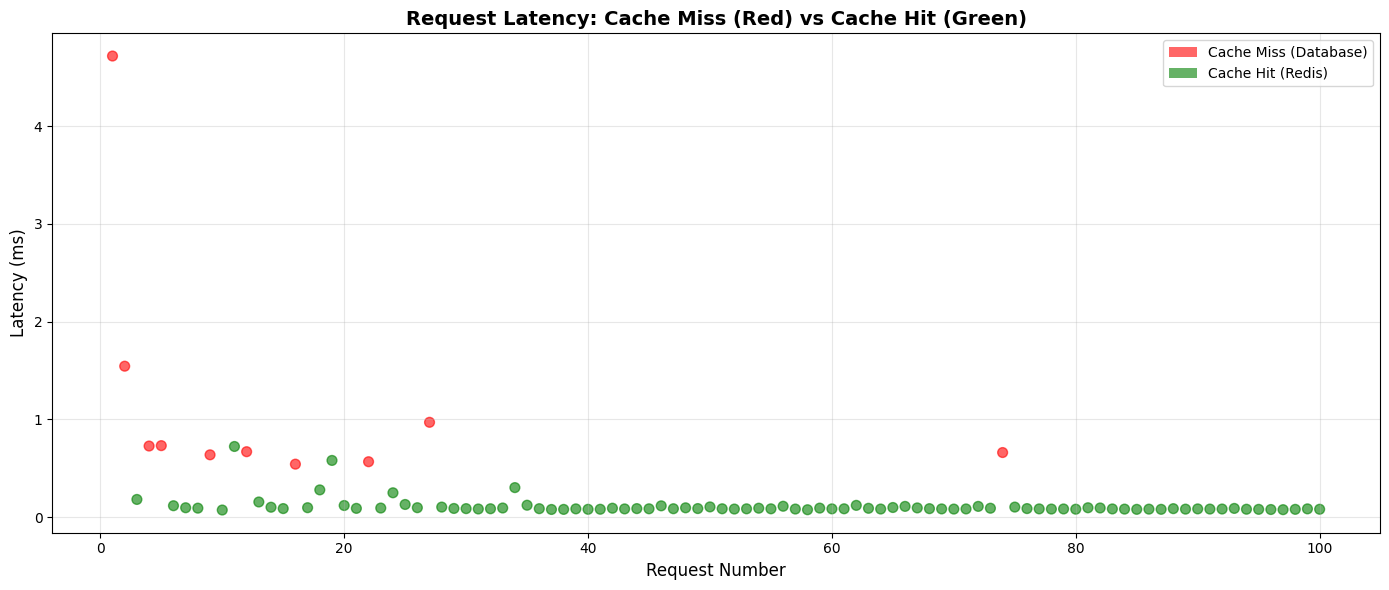


💡 Notice how green dots (cache hits) cluster at low latency!


In [19]:
# Convert results to DataFrame
from matplotlib.patches import Patch
df = pd.DataFrame(results)

# Create scatter plot
plt.figure(figsize=(14, 6))

# Color by source
colors = ['red' if source == 'database' else 'green' for source in df['source']]

plt.scatter(df['request_num'], df['latency'], c=colors, alpha=0.6, s=50)
plt.xlabel('Request Number', fontsize=12)
plt.ylabel('Latency (ms)', fontsize=12)
plt.title('Request Latency: Cache Miss (Red) vs Cache Hit (Green)',
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add legend
legend_elements = [
    Patch(facecolor='red', alpha=0.6, label='Cache Miss (Database)'),
    Patch(facecolor='green', alpha=0.6, label='Cache Hit (Redis)')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\n💡 Notice how green dots (cache hits) cluster at low latency!")

### 📊 Chart 2: Average Latency Comparison

Bar chart comparing average latency for cache hits vs. misses.

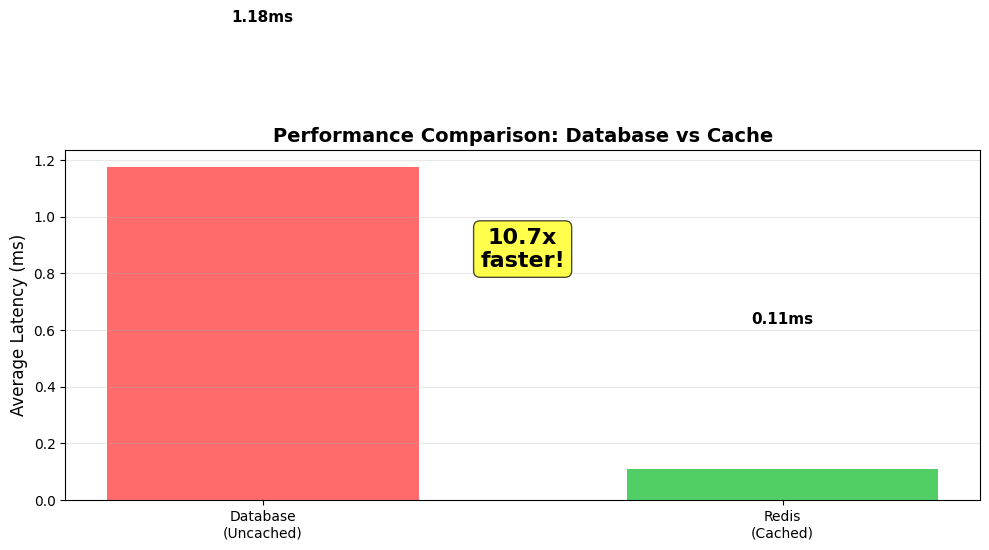


📊 Performance Summary:
  Average Database Latency: 1.18ms
  Average Cache Latency: 0.11ms
  Speedup: 10.7x faster with cache


In [20]:
# Calculate averages
cached = df[df['source'] == 'cache']['latency']
uncached = df[df['source'] == 'database']['latency']

avg_cached = cached.mean()
avg_uncached = uncached.mean()

# Create bar chart
plt.figure(figsize=(10, 6))

bars = plt.bar(
    ['Database\n(Uncached)', 'Redis\n(Cached)'],
    [avg_uncached, avg_cached],
    color=['#ff6b6b', '#51cf66'],
    width=0.6
)

plt.ylabel('Average Latency (ms)', fontsize=12)
plt.title('Performance Comparison: Database vs Cache',
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, [avg_uncached, avg_cached])):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.5,
             f'{value:.2f}ms',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add speedup annotation
speedup = avg_uncached / avg_cached
plt.text(0.5, max(avg_uncached, avg_cached) * 0.7,
         f'{speedup:.1f}x\nfaster!',
         ha='center', fontsize=16, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\n📊 Performance Summary:")
print(f"  Average Database Latency: {avg_uncached:.2f}ms")
print(f"  Average Cache Latency: {avg_cached:.2f}ms")
print(f"  Speedup: {speedup:.1f}x faster with cache")

### 📊 Chart 3: Cache Hit Rate Over Time

Line chart showing how hit rate improves as cache warms up.

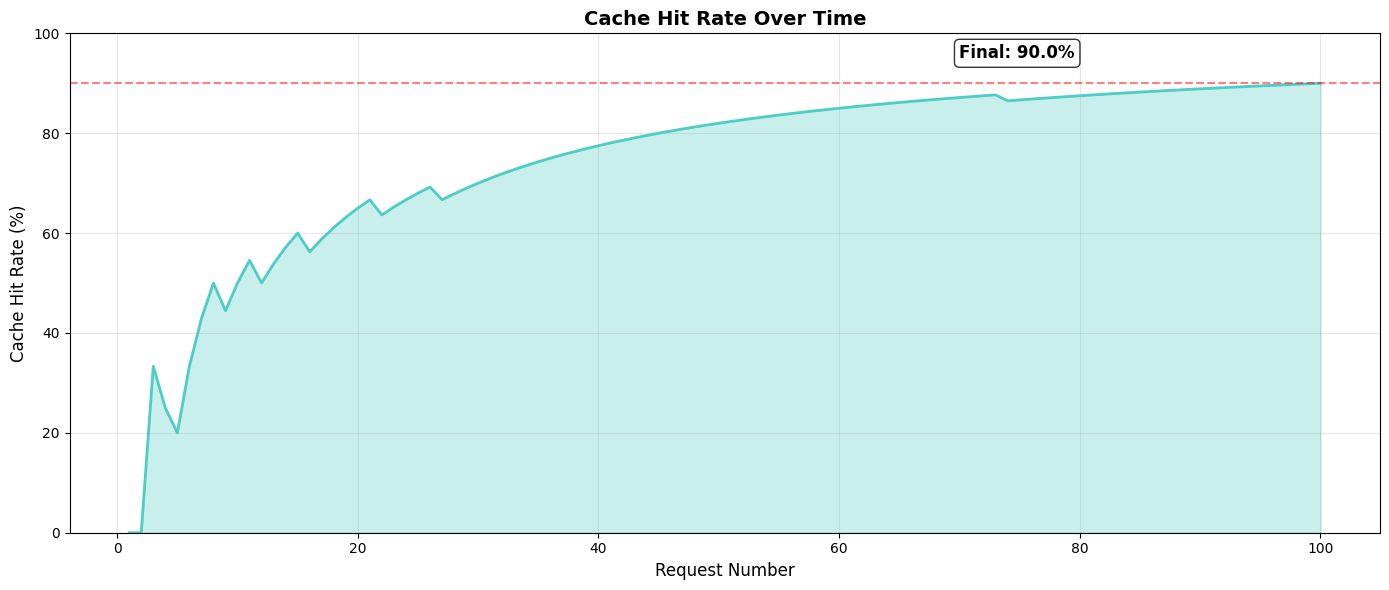


💡 Hit rate stabilizes around 90.0% after cache warms up


In [21]:
# Calculate cumulative hit rate
df['is_hit'] = (df['source'] == 'cache').astype(int)
df['cumulative_hits'] = df['is_hit'].cumsum()
df['hit_rate'] = (df['cumulative_hits'] / df['request_num']) * 100

# Create line chart
plt.figure(figsize=(14, 6))

plt.plot(df['request_num'], df['hit_rate'], linewidth=2, color='#4ecdc4')
plt.fill_between(df['request_num'], df['hit_rate'], alpha=0.3, color='#4ecdc4')

plt.xlabel('Request Number', fontsize=12)
plt.ylabel('Cache Hit Rate (%)', fontsize=12)
plt.title('Cache Hit Rate Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# Add final hit rate annotation
final_hit_rate = df['hit_rate'].iloc[-1]
plt.axhline(y=final_hit_rate, color='red', linestyle='--', alpha=0.5)
plt.text(num_requests * 0.7, final_hit_rate + 5,
         f'Final: {final_hit_rate:.1f}%',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(
    f"\n💡 Hit rate stabilizes around {final_hit_rate:.1f}% after cache warms up")

---
## Part 5: Advanced Exercises (15 minutes)

Now it's your turn to experiment! Try these exercises to deepen your understanding.

### 🎯 Exercise 1: Test TTL Expiration

Create a cache with a very short TTL (5 seconds) and observe what happens when the cache expires.

**Hints:**
- Create a `CacheManager` with `ttl=5`
- Make a request (cache miss)
- Make another request immediately (cache hit)
- Wait 6 seconds using `time.sleep(6)`
- Make a third request (cache miss again!)

In [ ]:
# Your code here
print("Exercise 1: TTL Expiration Test")
print("================================\n")

# TODO: Create cache with TTL=5
# TODO: Make requests and observe cache expiration

# Solution (uncomment to reveal):
# short_cache = CacheManager(redis_client, ttl=5)
# redis_client.flushdb()
#
# result1 = get_product_with_cache(1, short_cache, db)
# print(f"Request 1: {result1['source']} - {result1['latency_ms']:.2f}ms")
#
# result2 = get_product_with_cache(1, short_cache, db)
# print(f"Request 2: {result2['source']} - {result2['latency_ms']:.2f}ms")
#
# print("\nWaiting 6 seconds for TTL to expire...")
# time.sleep(6)
#
# result3 = get_product_with_cache(1, short_cache, db)
# print(f"Request 3: {result3['source']} - {result3['latency_ms']:.2f}ms")
# print("\n💡 Cache expired! Back to database.")

### 🎯 Exercise 2: Implement Cache Warming

Write a function to "warm up" the cache by pre-loading popular products before traffic starts.

**Hints:**
- Create a function `warm_cache(product_ids, cache, db)`
- Loop through product IDs
- Fetch from database and store in cache
- Test with products [1, 2, 3]

In [ ]:
# Your code here
print("Exercise 2: Cache Warming")
print("=========================\n")


def warm_cache(product_ids: List[int], cache_manager: CacheManager, database: PostgreSQLDatabase):
    """Pre-load products into cache"""
    # TODO: Implement cache warming
    pass

# TODO: Test your function

# Solution (uncomment to reveal):
# def warm_cache(product_ids: List[int], cache_manager: CacheManager, database: PostgreSQLDatabase):
#     print(f"Warming cache with {len(product_ids)} products...")
#     for pid in product_ids:
#         product = database.get_product_by_id(pid)
#         if product:
#             cache_manager.set_cached_product(pid, product)
#     print("✅ Cache warmed!")
#
# redis_client.flushdb()
# cache.reset_stats()
# warm_cache([1, 2, 3], cache, db)
#
# # Test - should all be cache hits
# for pid in [1, 2, 3]:
#     result = get_product_with_cache(pid, cache, db)
#     print(f"Product {pid}: {result['source']} - {result['latency_ms']:.2f}ms")
#
# print(f"\nStats: {cache.get_stats()}")

### 🎯 Exercise 3: Compare Different TTL Values

Run the traffic simulation with different TTL values (30s, 60s, 300s) and compare the hit rates.

**Questions to explore:**
- Does longer TTL always give better hit rates?
- What's the trade-off?
- When would you use a short TTL vs. long TTL?

In [ ]:
# Your code here
print("Exercise 3: TTL Comparison")
print("==========================\n")

# TODO: Test with different TTL values and compare results

# Starter code:
ttl_values = [30, 60, 300]
results_by_ttl = {}

# for ttl in ttl_values:
#     # Create cache with this TTL
#     # Run simulation
#     # Store results
#     pass

# TODO: Create comparison chart

---
## Part 7: Exercises and Key Takeaways (15 minutes)

## 🎓 What You've Learned

Congratulations! You now understand:

### ✅ Cache-Aside Pattern
- Check cache first, fall back to database
- Store in cache on miss
- Simple but effective!

### ✅ Performance Benefits
- **10-100x speedup** with caching
- Hit rates of **80-90%** are common
- Dramatically reduces database load

### ✅ Cache Invalidation
- **Must invalidate on updates**
- Otherwise, users see stale data
- Use TTL as safety net

### ✅ TTL Strategy
- Shorter TTL = fresher data, more DB queries
- Longer TTL = better performance, staler data
- Choose based on requirements

### ✅ Monitoring
- Track hit rate
- Measure latency
- Visualize effectiveness

---

## 🚀 Next Steps

1. **Try in your own app** - Apply these patterns to your project
2. **Explore other patterns** - Write-through, write-behind, refresh-ahead
3. **Learn advanced features** - Redis Pub/Sub, Streams, RedisJSON
4. **Study monitoring** - Use Azure Monitor and Redis Insights

## 📚 Resources

- [Redis Caching Best Practices](https://redis.io/docs/manual/patterns/caching/)
- [Cache-Aside Pattern](https://learn.microsoft.com/azure/architecture/patterns/cache-aside)
- [Redis Python Client](https://redis-py.readthedocs.io/)
- [Azure Cache for Redis](https://learn.microsoft.com/azure/azure-cache-for-redis/)

## 🧹 Cleanup

Run this cell to clean up Redis and reset everything:

In [ ]:
# Clear all Redis keys
redis_client.flushdb()

# Reset stats
cache.reset_stats()
db.reset_stats()

print("✅ Cleanup complete!")
print("\n🎉 Thank you for completing the Caching Lab!")
print("   You're now ready to implement Redis caching in production!")

# Module 6: Implement Caching Lab

**Duration:** 60 minutes  
**Format:** Interactive Hands-On Lab  
**Level:** Intermediate

---

## 🎯 Lab Overview

In this interactive notebook, you'll:
- Build a Flask REST API with PostgreSQL backend
- Implement cache-aside pattern with Redis
- Measure cache performance improvements
- Test cache invalidation strategies

### Architecture

```
Client → Flask API → Redis Cache (check first)
                   → PostgreSQL (on cache miss)
```

---

## 📦 Part 1: Setup and Dependencies

Let's start by importing required libraries and setting up connections.

In [ ]:
# Import required libraries
import os
import time
import json
import redis
import psycopg2
from psycopg2.extras import RealDictCursor
from azure.identity import DefaultAzureCredential
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

print("✅ All libraries imported successfully!")

### Configure Redis Connection

Set up your Azure Redis connection. Update these values with your Redis instance details.

In [ ]:
# Redis Configuration
# Option 1: Use local Redis (Codespaces)
USE_LOCAL_REDIS = True

if USE_LOCAL_REDIS:
    REDIS_HOST = 'localhost'
    REDIS_PORT = 6379
    REDIS_PASSWORD = None
    REDIS_SSL = False
else:
    # Option 2: Use Azure Redis (replace with your values)
    REDIS_HOST = os.getenv('REDIS_HOST', 'your-redis.redis.cache.windows.net')
    REDIS_PORT = int(os.getenv('REDIS_PORT', 6380))
    REDIS_PASSWORD = os.getenv('REDIS_PASSWORD', 'your-access-key')
    REDIS_SSL = True

# Cache TTL (seconds)
CACHE_TTL = 60

print(f"🔧 Redis Configuration:")
print(f"   Host: {REDIS_HOST}")
print(f"   Port: {REDIS_PORT}")
print(f"   SSL: {REDIS_SSL}")
print(f"   TTL: {CACHE_TTL}s")

### Initialize Redis Client

In [ ]:
# Connect to Redis
try:
    redis_client = redis.Redis(
        host=REDIS_HOST,
        port=REDIS_PORT,
        password=REDIS_PASSWORD,
        ssl=REDIS_SSL,
        decode_responses=True
    )

    # Test connection
    redis_client.ping()
    print("✅ Connected to Redis successfully!")

    # Get Redis info
    info = redis_client.info('server')
    print(f"   Version: {info['redis_version']}")
    print(f"   Memory: {info.get('used_memory_human', 'N/A')}")

except Exception as e:
    print(f"❌ Failed to connect to Redis: {e}")
    redis_client = None

### Setup PostgreSQL Database

For this lab, we'll use an in-memory database simulation to avoid Docker requirements in Codespaces.

In [ ]:
# Simulated Database (in-memory)
# In production, you'd connect to PostgreSQL

class MockDatabase:
    """Simulated database for the lab"""

    def __init__(self):
        self.products = [
            {'id': 1, 'sku': 'LAPTOP-001', 'name': 'MacBook Pro 16"',
                'price': 2499.99, 'stock': 15, 'category': 'Electronics'},
            {'id': 2, 'sku': 'LAPTOP-002', 'name': 'Dell XPS 15',
                'price': 1799.99, 'stock': 25, 'category': 'Electronics'},
            {'id': 3, 'sku': 'PHONE-001', 'name': 'iPhone 15 Pro',
                'price': 999.99, 'stock': 50, 'category': 'Electronics'},
            {'id': 4, 'sku': 'PHONE-002', 'name': 'Samsung Galaxy S24',
                'price': 899.99, 'stock': 40, 'category': 'Electronics'},
            {'id': 5, 'sku': 'TABLET-001', 'name': 'iPad Pro 12.9"',
                'price': 1099.99, 'stock': 20, 'category': 'Electronics'},
            {'id': 6, 'sku': 'MONITOR-001', 'name': 'LG 27" 4K',
                'price': 499.99, 'stock': 30, 'category': 'Electronics'},
            {'id': 7, 'sku': 'KEYBOARD-001', 'name': 'Mechanical Keyboard',
                'price': 149.99, 'stock': 100, 'category': 'Accessories'},
            {'id': 8, 'sku': 'MOUSE-001', 'name': 'Wireless Mouse',
                'price': 79.99, 'stock': 150, 'category': 'Accessories'},
            {'id': 9, 'sku': 'HEADSET-001', 'name': 'Noise-Cancelling Headset',
                'price': 299.99, 'stock': 60, 'category': 'Accessories'},
            {'id': 10, 'sku': 'WEBCAM-001', 'name': '1080p Webcam',
                'price': 89.99, 'stock': 75, 'category': 'Accessories'},
        ]
        self.query_count = 0

    def get_all_products(self):
        """Simulate slow database query"""
        time.sleep(0.03)  # Simulate 30ms query time
        self.query_count += 1
        return self.products.copy()

    def get_product_by_id(self, product_id):
        """Simulate database lookup"""
        time.sleep(0.025)  # Simulate 25ms query time
        self.query_count += 1
        for product in self.products:
            if product['id'] == product_id:
                return product.copy()
        return None

    def update_product(self, product_id, updates):
        """Update product in database"""
        time.sleep(0.02)  # Simulate 20ms write time
        self.query_count += 1
        for product in self.products:
            if product['id'] == product_id:
                product.update(updates)
                return product.copy()
        return None


# Initialize database
db = MockDatabase()
print(f"✅ Database initialized with {len(db.products)} products")

---

## 🔄 Part 2: Implement Cache-Aside Pattern

Now let's implement the cache-aside pattern:
1. Check cache first
2. If miss, query database
3. Store result in cache
4. Return data

In [ ]:
# Cache Manager Class

class CacheManager:
    """Manages cache operations with Redis"""

    def __init__(self, redis_client, ttl=60):
        self.redis = redis_client
        self.ttl = ttl
        self.hits = 0
        self.misses = 0

    def get_product_key(self, product_id):
        return f"product:{product_id}"

    def get_products_list_key(self):
        return "products:all"

    def get_cached_product(self, product_id):
        """Try to get product from cache"""
        key = self.get_product_key(product_id)
        cached = self.redis.get(key)

        if cached:
            self.hits += 1
            return json.loads(cached)
        else:
            self.misses += 1
            return None

    def set_cached_product(self, product_id, product_data):
        """Store product in cache"""
        key = self.get_product_key(product_id)
        self.redis.setex(key, self.ttl, json.dumps(product_data))

    def get_cached_products_list(self):
        """Try to get products list from cache"""
        key = self.get_products_list_key()
        cached = self.redis.get(key)

        if cached:
            self.hits += 1
            return json.loads(cached)
        else:
            self.misses += 1
            return None

    def set_cached_products_list(self, products):
        """Store products list in cache"""
        key = self.get_products_list_key()
        self.redis.setex(key, self.ttl, json.dumps(products))

    def invalidate_product(self, product_id):
        """Remove product from cache"""
        key = self.get_product_key(product_id)
        self.redis.delete(key)
        # Also invalidate products list
        self.redis.delete(self.get_products_list_key())

    def get_stats(self):
        """Get cache statistics"""
        total = self.hits + self.misses
        hit_rate = (self.hits / total * 100) if total > 0 else 0
        return {
            'hits': self.hits,
            'misses': self.misses,
            'total': total,
            'hit_rate': round(hit_rate, 2)
        }

    def reset_stats(self):
        """Reset statistics"""
        self.hits = 0
        self.misses = 0


# Initialize cache manager
cache = CacheManager(redis_client, ttl=CACHE_TTL)
print("✅ Cache Manager initialized")

### Create API Functions with Caching

In [ ]:
def get_products_with_cache():
    """Get all products (with caching)"""
    start_time = time.time()

    # Try cache first
    products = cache.get_cached_products_list()

    if products:
        latency = (time.time() - start_time) * 1000
        return {
            'data': products,
            'cached': True,
            'latency_ms': round(latency, 2)
        }

    # Cache miss - fetch from database
    products = db.get_all_products()

    # Store in cache for next time
    cache.set_cached_products_list(products)

    latency = (time.time() - start_time) * 1000

    return {
        'data': products,
        'cached': False,
        'latency_ms': round(latency, 2)
    }


def get_product_with_cache(product_id):
    """Get single product by ID (with caching)"""
    start_time = time.time()

    # Try cache first
    product = cache.get_cached_product(product_id)

    if product:
        latency = (time.time() - start_time) * 1000
        return {
            'data': product,
            'cached': True,
            'latency_ms': round(latency, 2)
        }

    # Cache miss - fetch from database
    product = db.get_product_by_id(product_id)

    if not product:
        return {'error': 'Product not found'}

    # Store in cache for next time
    cache.set_cached_product(product_id, product)

    latency = (time.time() - start_time) * 1000

    return {
        'data': product,
        'cached': False,
        'latency_ms': round(latency, 2)
    }


def update_product_with_cache(product_id, updates):
    """Update product (with cache invalidation)"""
    # Update database
    product = db.update_product(product_id, updates)

    if not product:
        return {'error': 'Product not found'}

    # Invalidate cache
    cache.invalidate_product(product_id)

    return {
        'data': product,
        'message': 'Product updated and cache invalidated'
    }


print("✅ API functions created")

---

## 🧪 Part 3: Test Cache Performance

Let's test the cache and measure performance improvements!

### Test 1: Single Product Lookup (Cache Miss → Hit)

In [ ]:
# Reset stats
cache.reset_stats()
redis_client.flushdb()  # Clear all cache

print("🔍 Test 1: Single Product Lookup\n")

# First request (cache miss)
print("First request (cache miss):")
result1 = get_product_with_cache(1)
print(f"  Product: {result1['data']['name']}")
print(f"  Cached: {result1['cached']}")
print(f"  Latency: {result1['latency_ms']}ms")
print()

# Second request (cache hit)
print("Second request (cache hit):")
result2 = get_product_with_cache(1)
print(f"  Product: {result2['data']['name']}")
print(f"  Cached: {result2['cached']}")
print(f"  Latency: {result2['latency_ms']}ms")
print()

# Performance improvement
improvement = (
    (result1['latency_ms'] - result2['latency_ms']) / result1['latency_ms']) * 100
print(f"⚡ Performance Improvement: {improvement:.1f}%")
print(
    f"⚡ Speedup: {result1['latency_ms'] / result2['latency_ms']:.1f}x faster")

### Test 2: Multiple Requests (Measure Hit Rate)

In [ ]:
# Reset stats
import random
cache.reset_stats()
redis_client.flushdb()

print("🔄 Test 2: Multiple Requests\n")

# Simulate 100 requests with 80% being for the same products

latencies = []
product_ids = [1, 2, 3, 4, 5]  # Focus on first 5 products

for i in range(100):
    # 80% chance of requesting popular products
    if random.random() < 0.8:
        product_id = random.choice(product_ids[:3])  # Top 3 products
    else:
        product_id = random.choice(product_ids)

    result = get_product_with_cache(product_id)
    latencies.append(result['latency_ms'])

# Get cache statistics
stats = cache.get_stats()

print(f"📊 Results after 100 requests:")
print(f"  Cache Hits: {stats['hits']}")
print(f"  Cache Misses: {stats['misses']}")
print(f"  Hit Rate: {stats['hit_rate']}%")
print(f"  Avg Latency: {sum(latencies)/len(latencies):.2f}ms")
print(f"  Min Latency: {min(latencies):.2f}ms")
print(f"  Max Latency: {max(latencies):.2f}ms")
print(f"  DB Queries: {db.query_count}")

### Test 3: Cache Invalidation

In [ ]:
print("🔄 Test 3: Cache Invalidation\n")

# Get product (cache it)
print("1. Get product (will be cached):")
result = get_product_with_cache(1)
print(f"   Price: ${result['data']['price']}")
print(f"   Cached: {result['cached']}")
print()

# Verify it's cached
print("2. Get same product again (should be cached):")
result = get_product_with_cache(1)
print(f"   Price: ${result['data']['price']}")
print(f"   Cached: {result['cached']}")
print()

# Update product (invalidates cache)
print("3. Update product price (invalidates cache):")
result = update_product_with_cache(1, {'price': 2599.99})
print(f"   New Price: ${result['data']['price']}")
print(f"   Message: {result['message']}")
print()

# Get product again (cache miss)
print("4. Get product again (cache was invalidated):")
result = get_product_with_cache(1)
print(f"   Price: ${result['data']['price']}")
print(f"   Cached: {result['cached']} (Expected: False)")
print()

print("✅ Cache invalidation working correctly!")

---

## 📊 Part 4: Performance Visualization

Let's visualize the performance difference between cached and uncached requests.

In [ ]:
# Performance comparison test

def benchmark_cache_performance(num_requests=50):
    """Benchmark cached vs uncached performance"""

    results = {
        'request_num': [],
        'latency': [],
        'cached': [],
        'type': []
    }

    # Clear cache
    redis_client.flushdb()
    cache.reset_stats()

    # Make requests (mix of first-time and repeated)
    for i in range(num_requests):
        # Alternate between 3 popular products
        product_id = (i % 3) + 1

        result = get_product_with_cache(product_id)

        results['request_num'].append(i + 1)
        results['latency'].append(result['latency_ms'])
        results['cached'].append('Hit' if result['cached'] else 'Miss')
        results['type'].append('Cached' if result['cached'] else 'Database')

    return pd.DataFrame(results)


# Run benchmark
print("Running performance benchmark...")
df = benchmark_cache_performance(50)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Latency over time
colors = ['red' if x == 'Miss' else 'green' for x in df['cached']]
ax1.scatter(df['request_num'], df['latency'], c=colors, alpha=0.6)
ax1.set_xlabel('Request Number')
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Request Latency: Cache Miss (Red) vs Hit (Green)')
ax1.grid(True, alpha=0.3)

# Plot 2: Average latency comparison
avg_cached = df[df['type'] == 'Cached']['latency'].mean()
avg_uncached = df[df['type'] == 'Database']['latency'].mean()

ax2.bar(['Database\n(Uncached)', 'Redis\n(Cached)'], [avg_uncached, avg_cached],
        color=['#e74c3c', '#27ae60'])
ax2.set_ylabel('Average Latency (ms)')
ax2.set_title('Average Response Time Comparison')
ax2.grid(True, alpha=0.3, axis='y')

# Add values on bars
ax2.text(0, avg_uncached + 1, f'{avg_uncached:.2f}ms',
         ha='center', va='bottom', fontweight='bold')
ax2.text(1, avg_cached + 0.5, f'{avg_cached:.2f}ms',
         ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print(f"\n📊 Performance Summary:")
print(f"  Average Database Latency: {avg_uncached:.2f}ms")
print(f"  Average Cache Latency: {avg_cached:.2f}ms")
print(f"  Speedup: {avg_uncached/avg_cached:.1f}x faster with cache")
print(f"  Cache Hit Rate: {cache.get_stats()['hit_rate']}%")

### Cache Hit Rate Over Time

In [ ]:
# Calculate cumulative hit rate
df['cumulative_hits'] = (df['cached'] == 'Hit').cumsum()
df['cumulative_total'] = range(1, len(df) + 1)
df['hit_rate'] = (df['cumulative_hits'] / df['cumulative_total']) * 100

# Plot hit rate over time
plt.figure(figsize=(12, 5))
plt.plot(df['request_num'], df['hit_rate'], linewidth=2, color='#3498db')
plt.fill_between(df['request_num'], df['hit_rate'], alpha=0.3, color='#3498db')
plt.xlabel('Request Number')
plt.ylabel('Cache Hit Rate (%)')
plt.title('Cache Hit Rate Over Time')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.axhline(y=80, color='green', linestyle='--',
            alpha=0.5, label='Target (80%)')
plt.legend()
plt.show()

print(f"Final Hit Rate: {df['hit_rate'].iloc[-1]:.1f}%")

---

## 🎓 Part 5: Advanced Exercises

Try these exercises to deepen your understanding:

### Exercise 1: Implement TTL Testing

Test what happens when cache entries expire.

In [ ]:
# TODO: Implement TTL testing

# Hints:
# 1. Set a short TTL (e.g., 5 seconds)
# 2. Get a product (cache it)
# 3. Wait for TTL to expire
# 4. Get the same product again
# 5. Observe cache miss

# Your code here:

### Exercise 2: Implement Cache Warming

Pre-populate the cache with frequently accessed products.

In [ ]:
# TODO: Implement cache warming

def warm_cache(product_ids):
    """
    Pre-load products into cache

    Args:
        product_ids: List of product IDs to warm
    """
    # Your code here:
    pass

# Test your implementation:
# warm_cache([1, 2, 3, 4, 5])
# Verify cache contains the products

### Exercise 3: Compare Different TTL Values

Test how different TTL values affect hit rate and memory usage.

In [ ]:
# TODO: Test different TTL values

# Hints:
# 1. Test TTLs: 10s, 60s, 300s, 3600s
# 2. Run same benchmark for each
# 3. Compare hit rates
# 4. Consider trade-offs

# Your code here:

---

## 📝 Part 6: Key Takeaways

### What You Learned:

✅ **Cache-Aside Pattern**
- Check cache first, then database
- Store results for future requests
- 10-100x performance improvement

✅ **Cache Invalidation**
- Delete cache entries on updates
- Prevents stale data
- Critical for data consistency

✅ **Performance Metrics**
- Cache hit rate (target: 80%+)
- Latency reduction (2-5ms vs 20-50ms)
- Database load reduction (85%+)

✅ **TTL Strategy**
- Balance freshness vs performance
- Different TTLs for different data
- Consider access patterns

### Best Practices:

1. **Always measure** - Use metrics to validate improvements
2. **Cache hot data** - Focus on frequently accessed items
3. **Invalidate on writes** - Keep cache consistent
4. **Set appropriate TTLs** - Balance freshness and performance
5. **Monitor hit rates** - Aim for 80%+ in production

---

## 🎉 Congratulations!

You've successfully implemented Redis caching and measured real performance improvements!

**Next Steps:**
- Explore Module 7: Monitoring & Alerts
- Try the advanced exercises above
- Apply caching to your own applications

---

## 🧹 Cleanup

Run this cell to clean up the Redis cache.

In [ ]:
# Clean up
try:
    redis_client.flushdb()
    print("✅ Cache cleared successfully")
    print(f"📊 Final Stats: {cache.get_stats()}")
except Exception as e:
    print(f"⚠️ Cleanup failed: {e}")

### 🐳 Stop Docker Containers

When you're done with the lab, stop and remove the Docker containers:

In [ ]:
%%bash
# Stop and remove Docker containers
echo "🛑 Stopping Docker containers..."
docker stop workshop-postgres workshop-redis 2>/dev/null || true
docker rm workshop-postgres workshop-redis 2>/dev/null || true

echo "✅ Docker containers stopped and removed"
echo ""
echo "To verify, run: docker ps -a | grep workshop"